In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



In [2]:
dolphin_pewds_biber_df = pd.read_csv("dolphin_pewdipie_biber_features.csv", index_col="doc_id")
phi_pewds_biber_df = pd.read_csv("phi4_pewdiepie_biber_features.csv", index_col="doc_id")
human_pewds_biber_df= pd.read_csv("human_pewdipie_biber_features.csv", index_col="doc_id")

llama_flatearth_biber_df = pd.read_csv("llama3_2_flatearth_biber_features.csv", index_col="doc_id")
phi_flatearth_biber_df = pd.read_csv("phi4_flatearth_biber_features.csv", index_col="doc_id")
human_flatearth_biber_df= pd.read_csv("human_flatearth_biber_features.csv", index_col="doc_id")

deepseek_crypto_biber_df = pd.read_csv("deepseek_CryptoMarkets_biber_features.csv", index_col="doc_id")
phi_crypto_biber_df = pd.read_csv("phi4_CryptoMarkets_biber_features.csv", index_col="doc_id")
human_cypto_biber_df = pd.read_csv("human_CryptoMarkets_biber_features.csv", index_col="doc_id")

# # Optional
llama_cornell_biber_df = pd.read_csv("llama3-2_Cornell_biber_features.csv", index_col="doc_id")
human_cornell_biber_df= pd.read_csv("human_Cornell_biber_features_10k.csv", index_col="doc_id")
dolphin_AITA_biber_df = pd.read_csv("dolphin_AmItheAsshole_biber_features.csv", index_col="doc_id")
human_AITA_biber_df = pd.read_csv("human_AmItheAsshole_biber_features_10k.csv", index_col="doc_id")

# User profile
user_profiles_df = pd.read_csv("user_profiles_biber_features_unaggregated.csv", index_col=["UserID", "subreddit"])

# User profile averages
user_profiles_avg_df = pd.read_csv("user_profiles_biber_features.csv", index_col="doc_id")

# Datasets

### 1. Posts Dataset

In [36]:
# All AI posts combined
ai_df = pd.concat([dolphin_pewds_biber_df,
                   phi_pewds_biber_df,
                   llama_flatearth_biber_df,
                   phi_flatearth_biber_df,
                   deepseek_crypto_biber_df,
                   phi_crypto_biber_df])

ai_df = ai_df.reset_index(drop=True)
ai_df.head()

# All human posts combined
human_df = pd.concat([human_pewds_biber_df,
                      human_flatearth_biber_df,
                      human_cypto_biber_df])

X_posts = pd.concat([ai_df, human_df])
y_posts = np.vstack([
    np.zeros(dtype=np.int32, shape=(ai_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(human_df.shape[0], 1))
])

X_posts_train, X_posts_test, y_posts_train, y_posts_test = train_test_split(
    X_posts, y_posts, test_size=0.3, random_state=42, shuffle=True
)


### 2. Profiles Dataset

In [37]:
# Mega dataset with all human profiles
X_posts_large = pd.concat([ai_df, user_profiles_df])
y_posts_large = np.vstack([
    np.zeros(dtype=np.int32, shape=(ai_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(user_profiles_df.shape[0], 1))
])

# AI avg Profiles
ai_df['group'] = ai_df.index // 10
ai_profiles_df = ai_df.groupby('group').mean()
ai_profiles_df = ai_profiles_df.reset_index(drop=True)

X_profiles = pd.concat([ai_profiles_df, user_profiles_avg_df])
y_profiles = np.vstack([
    np.zeros(dtype=np.int32, shape=(ai_profiles_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(user_profiles_avg_df.shape[0], 1))
])


X_profiles_train, X_profiles_test, y_profiles_train, y_profiles_test = train_test_split(
    X_profiles, y_profiles, test_size=0.3, random_state=42, shuffle=True
)

### 3. Validation set (P1 dataset)

In [38]:
val_ai_df = pd.concat([llama_cornell_biber_df, dolphin_AITA_biber_df])
val_human_df = pd.concat([human_cornell_biber_df, human_AITA_biber_df])

X_val = pd.concat([val_ai_df, val_human_df])
y_val = np.vstack([
    np.zeros(dtype=np.int32, shape=(val_ai_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(val_human_df.shape[0], 1))
])

# Post Classification

In [66]:
posts_results = {}
profiles_results = {}
posts_profiles_results = {}

## Random Forests Classifer

### Random forests trained on posts

In [79]:
# Posts classification
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=7)
rf.fit(X_posts_train, y_posts_train)

y_posts_pred = rf.predict(X_posts_test)

# Validation on profiles dataset
y_profiles_pred = rf.predict(X_profiles)

# Validation on P1 dataset
y_val_pred = rf.predict(X_val)

rf_importance = pd.DataFrame({
    'feature': X_posts_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

posts_results["Random Forest"] = {
    "Posts Dataset" : accuracy_score(y_posts_test, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}

print(f"Random Forest Trained on Posts Dataset, Test Accuracy score: {accuracy_score(y_posts_test, y_posts_pred)}")
print(f"{'='*100}")
print(f"Random Forest Posts Validated on User and AI profiles, Accuracy score: {accuracy_score(y_profiles, y_profiles_pred)}")
print(f"Random Forest Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")

Random Forest Trained on Posts Dataset, Test Accuracy score: 0.9654353953419375
Random Forest Posts Validated on User and AI profiles, Accuracy score: 0.2522829154906193
Random Forest Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.8531375515100934


In [9]:
print(classification_report(y_posts_test, y_posts_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9002
           1       0.95      0.94      0.95      4480

    accuracy                           0.97     13482
   macro avg       0.96      0.96      0.96     13482
weighted avg       0.97      0.97      0.97     13482



### Random forests trained on profiles

In [77]:
# Profiles classification
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=7)
rf.fit(X_profiles_train, y_profiles_train)

y_profiles_pred = rf.predict(X_profiles_test)

# Validation on posts dataset
y_posts_pred = rf.predict(X_posts)

# Validation on P1 dataset
y_val_pred = rf.predict(X_val)

rf_importance = pd.DataFrame({
    'feature': X_posts_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

profiles_results["Random Forest"] = {
    "Posts Dataset" : accuracy_score(y_posts, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles_test, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}


print(f"Random Forest Trained on Profiles Dataset, Test Accuracy score: {accuracy_score(y_profiles_test, y_profiles_pred)}")
print(f"{'='*100}")
print(f"Random Forest Profiles Validated on Posts, Accuracy score: {accuracy_score(y_posts, y_posts_pred)}")
print(f"Random Forest Profiles Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")

Random Forest Trained on Profiles Dataset, Test Accuracy score: 0.9994465965688988
Random Forest Profiles Validated on Posts, Accuracy score: 0.5837468568503972
Random Forest Profiles Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.4876636586510876


### Random forests trained on posts, tested on profiles using individual posts

In [123]:
# Posts classification but used for profiles
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=7)
rf.fit(X_posts_train, y_posts_train)

# Validation on posts_large dataset
y_posts_large_pred = rf.predict(X_posts_large)

posts_profiles_results["Random Forest"] = {
    "Posts Dataset (Large)" : accuracy_score(y_posts_large, y_posts_large_pred)
}

print(f"Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: {accuracy_score(y_posts_large, y_posts_large_pred)}")
print(classification_report(y_posts_large, y_posts_large_pred))

Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: 0.7788522987857599
              precision    recall  f1-score   support

           0       0.39      0.98      0.55     29999
           1       1.00      0.75      0.85    182809

    accuracy                           0.78    212808
   macro avg       0.69      0.86      0.70    212808
weighted avg       0.91      0.78      0.81    212808



Computing Random Forest importance...
Computing Gradient Boosting importance...
Computing Logistic Regression coefficients...
Computing KS statistics...


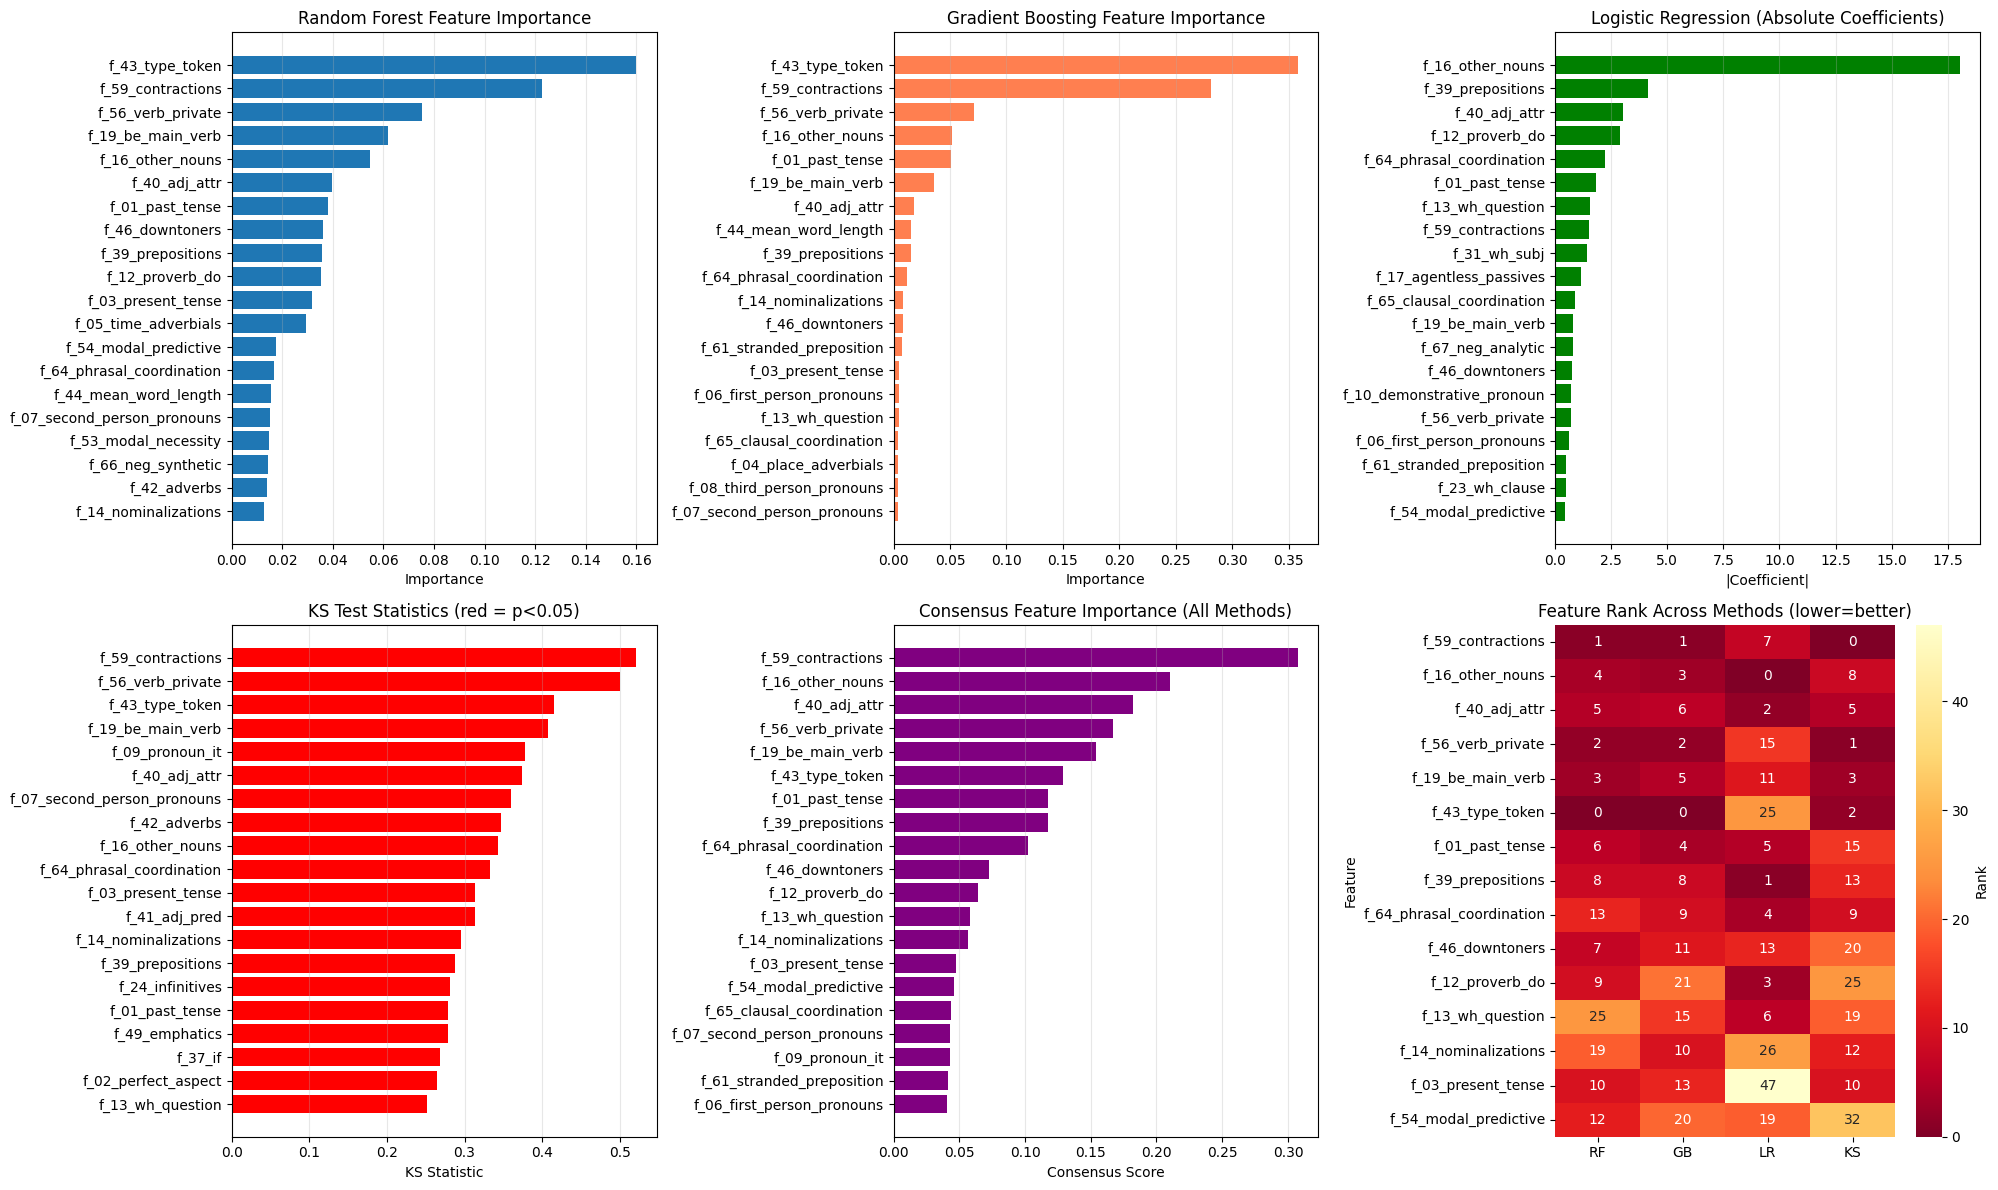

,feature,rf_rank,gb_rank,lr_rank,ks_rank,avg_rank
1,f_59_contractions,1,1,7,0,2.25
4,f_16_other_nouns,4,3,0,8,3.75
5,f_40_adj_attr,5,6,2,5,4.50
2,f_56_verb_private,2,2,15,1,5.00
3,f_19_be_main_verb,3,5,11,3,5.50
...,...,...,...,...,...,...
64,f_32_wh_obj,64,62,34,64,56.00
55,f_28_present_participle_whiz,55,64,54,58,57.75
62,f_30_that_obj,62,66,58,59,61.25
66,f_33_pied_piping,66,63,56,66,62.75


In [ ]:
visualize_feature_importance(X_profiles, y_profiles, top_n=20)

## Logistic Regression Classifier

### Logistic Regression Classifier on posts

In [70]:
lr = LogisticRegression(max_iter=1000, random_state=42)

scaler = StandardScaler()
X_posts_train_scaled = scaler.fit_transform(X_posts_train)

lr.fit(X_posts_train_scaled, y_posts_train)

X_posts_test_scaled = scaler.transform(X_posts_test)
y_posts_pred = lr.predict(X_posts_test_scaled)

# Validation on profiles dataset
X_profiles_scaled = scaler.transform(X_profiles)
y_profiles_pred = lr.predict(X_profiles_scaled)

# Validation on P1 dataset
y_val_pred = lr.predict(X_val)

posts_results["Logistic Regression"] = {
    "Posts Dataset" : accuracy_score(y_posts_test, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}

print(f"Logistic Regression Classifier Trained on Posts Dataset, Test Accuracy score: {accuracy_score(y_posts_test, y_posts_pred)}")
print(f"{'='*100}")
print(f"Logistic Regression Classifier Posts Validated on User and AI profiles, Accuracy score: {accuracy_score(y_profiles, y_profiles_pred)}")
print(f"Logistic Regression Classifier Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")

Logistic Regression Classifier Trained on Posts Dataset, Test Accuracy score: 0.9179646936656283
Logistic Regression Classifier Posts Validated on User and AI profiles, Accuracy score: 0.26075045658309814
Logistic Regression Classifier Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.396614678420531


### Logistic Regression Classifier on profiles

In [71]:
lr = LogisticRegression(max_iter=1000, random_state=42)

scaler = StandardScaler()
X_profiles_train_scaled = scaler.fit_transform(X_profiles_train)

lr.fit(X_profiles_train_scaled, y_profiles_train)

X_profiles_test_scaled = scaler.transform(X_profiles_test)
y_profiles_test_pred = lr.predict(X_profiles_test_scaled)

# Validation on posts dataset
X_posts_scaled = scaler.transform(X_posts)
y_posts_pred = lr.predict(X_posts_scaled)

# Validation on P1 dataset
y_val_pred = lr.predict(X_val)

profiles_results["Logistic Regression"] = {
    "Posts Dataset" : accuracy_score(y_posts, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles_test, y_profiles_test_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred),
}

print(f"Logistic Regression Classifier Trained on Profiles Dataset, Test Accuracy score: {accuracy_score(y_profiles_test, y_profiles_test_pred)}")
print(f"{'='*100}")
print(f"Logistic Regression Classifier Validated on Posts, Accuracy score: {accuracy_score(y_posts, y_posts_pred)}")
print(f"Logistic Regression Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")

Logistic Regression Classifier Trained on Profiles Dataset, Test Accuracy score: 0.996956281128943
Logistic Regression Classifier Validated on Posts, Accuracy score: 0.8135027481697412
Logistic Regression Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.430285326795681


### Logistic Regression classifier trained on posts, tested on profiles using individual posts

In [72]:
lr = LogisticRegression(max_iter=1000, random_state=42)

scaler = StandardScaler()
X_posts_train_scaled = scaler.fit_transform(X_posts_train)

lr.fit(X_posts_train_scaled, y_posts_train)

# Validation on posts_large dataset
X_posts_large_scaled = scaler.transform(X_posts_large)

nan_mask = np.isnan(X_posts_large_scaled)
clean_rows = ~(nan_mask.any(axis=1))
X_posts_large_scaled = X_posts_large_scaled[clean_rows]
y_posts_large_clean = y_posts_large[clean_rows]

y_posts_large_pred = lr.predict(X_posts_large_scaled)

posts_profiles_results["Logistic Regression"] = {
    "Posts Dataset (Large)" : accuracy_score(y_posts_large_clean, y_posts_large_pred),
}

print(f"Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: {accuracy_score(y_posts_large_clean, y_posts_large_pred)}")
print(classification_report(y_posts_large_clean, y_posts_large_pred))

Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: 0.6408998185698036
              precision    recall  f1-score   support

           0       0.28      0.96      0.43     29999
           1       0.99      0.59      0.74    182755

    accuracy                           0.64    212754
   macro avg       0.63      0.77      0.58    212754
weighted avg       0.89      0.64      0.69    212754



## Gradient Boosting Classifier

### Gradient Boosting Classifier on posts

In [74]:
# Posts classification
gb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=7)
gb.fit(X_posts_train, y_posts_train)

y_posts_pred = gb.predict(X_posts_test)

# Validation on profiles dataset
y_profiles_pred = gb.predict(X_profiles)

# Validation on P1 dataset
y_val_pred = gb.predict(X_val)

posts_results["Gradient Boosting"] = {
    "Posts Dataset" : accuracy_score(y_posts_test, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}

print(f"Gradient Boosting Classifier Trained on Posts Dataset, Test Accuracy score: {accuracy_score(y_posts_test, y_posts_pred)}")
print(f"{'='*100}")
print(f"Gradient Boosting Posts Classifier Validated on User and AI profiles, Accuracy score: {accuracy_score(y_profiles, y_profiles_pred)}")
print(f"Gradient Boosting Posts Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")

Gradient Boosting Classifier Trained on Posts Dataset, Test Accuracy score: 0.9751520545913069
Gradient Boosting Posts Classifier Validated on User and AI profiles, Accuracy score: 0.3223476672754441
Gradient Boosting Posts Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.8827656355954306


### Gradient Boosting Classifier on profiles

In [75]:
# Profiles classification
gb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=7)
gb.fit(X_profiles_train, y_profiles_train)

y_profiles_pred = gb.predict(X_profiles_test)

# Validation on posts dataset
y_posts_pred = gb.predict(X_posts)

# Validation on P1 dataset
y_val_pred = gb.predict(X_val)

profiles_results["Gradient Boosting"] = {
    "Posts Dataset" : accuracy_score(y_posts, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles_test, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred),
}

print(f"Gradient Boosting Classifier Trained on Profiles Dataset, Test Accuracy score: {accuracy_score(y_profiles_test, y_profiles_pred)}")
print(f"{'='*100}")
print(f"Gradient Boosting Profiles Classifier Validated on Posts, Accuracy score: {accuracy_score(y_posts, y_posts_pred)}")
print(f"Gradient Boosting Profiles Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")

Gradient Boosting Classifier Trained on Profiles Dataset, Test Accuracy score: 0.9980630879911455
Gradient Boosting Profiles Classifier Validated on Posts, Accuracy score: 0.5249115467633904
Gradient Boosting Profiles Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.4937927077356424


### Gradient Boosting Classifier trained on posts, tested on profiles using individual posts

In [76]:
# Posts classification but used for profiles
gb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=7)
gb.fit(X_posts_train, y_posts_train)

# Validation on posts_large dataset
nan_mask = np.isnan(X_posts_large)
clean_rows = ~(nan_mask.any(axis=1))
X_posts_large_clean = X_posts_large[clean_rows]
y_posts_large_clean = y_posts_large[clean_rows]

y_posts_large_pred = gb.predict(X_posts_large_clean)

posts_profiles_results["Gradient Boosting"] = {
    "Posts Dataset (Large)" : accuracy_score(y_posts_large_clean, y_posts_large_pred),
}

print(f"Gradient Boosting Posts Classifier, Validated on Profile's individual posts Accuracy score: {accuracy_score(y_posts_large_clean, y_posts_large_pred)}")
print(classification_report(y_posts_large_clean, y_posts_large_pred))

Gradient Boosting Posts Classifier, Validated on Profile's individual posts Accuracy score: 0.8610836929035411
              precision    recall  f1-score   support

           0       0.50      0.99      0.67     29999
           1       1.00      0.84      0.91    182755

    accuracy                           0.86    212754
   macro avg       0.75      0.92      0.79    212754
weighted avg       0.93      0.86      0.88    212754



# Plotting the classification results

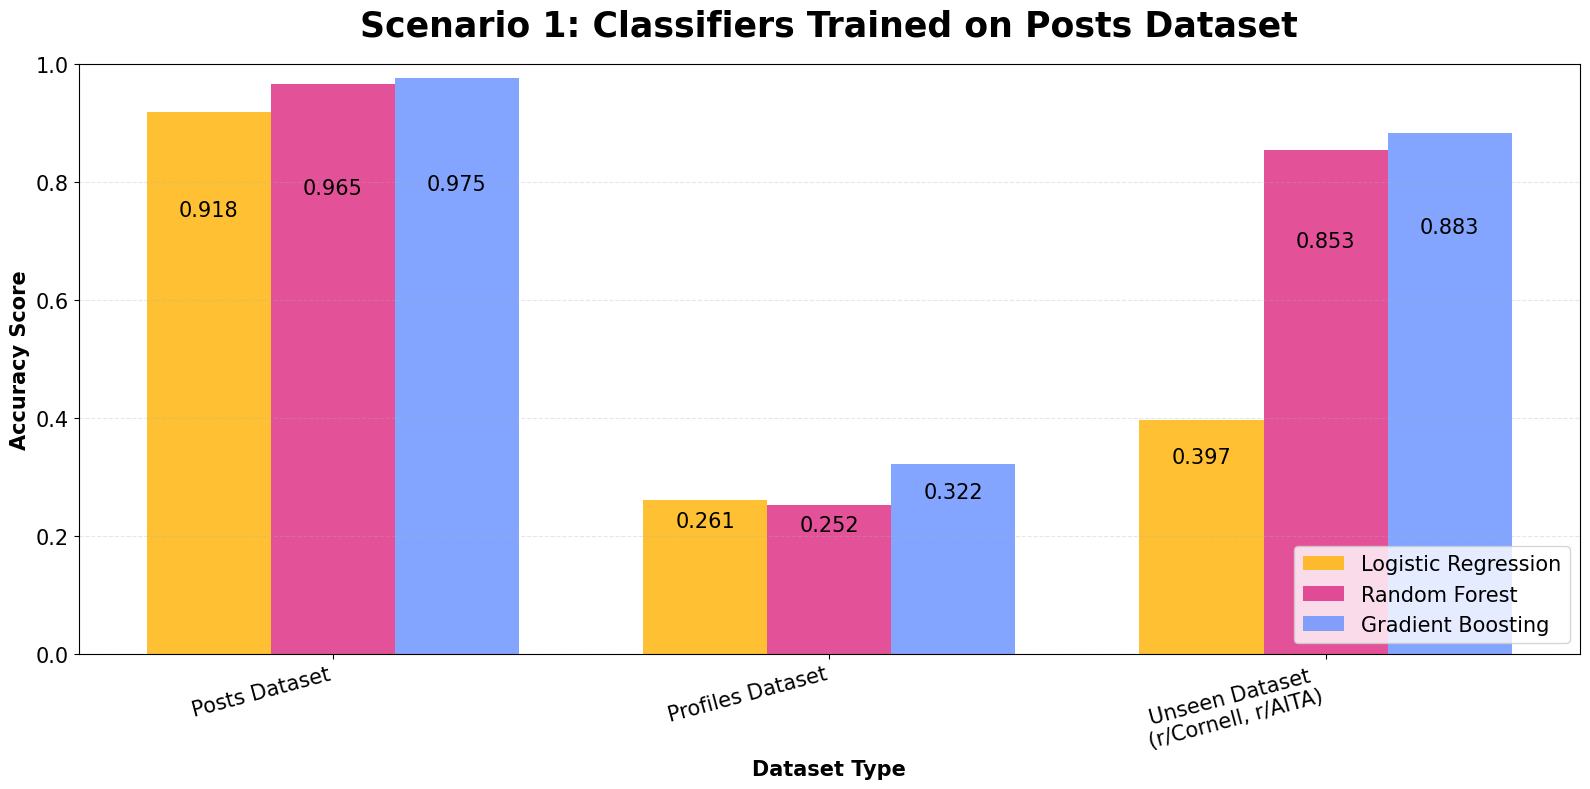

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for each classifier
colors = ['#FFB200', '#DC267F', '#648FFF']
classifiers = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# ===== PLOT 1: Trained on Posts Dataset =====
plt.figure(figsize=(16, 8))
test_types = list(posts_results['Logistic Regression'].keys())
for i in range(len(test_types)):
    if test_types[i] == "Unseen Dataset":
        test_types[i] = "Unseen Dataset \n (r/Cornell, r/AITA)"
        break

x = np.arange(len(test_types))
width = 0.25

for idx, classifier in enumerate(classifiers):
    values = list(posts_results[classifier].values())
    offset = (idx - 1) * width
    bars = plt.bar(x + offset, values, width, label=classifier, color=colors[idx], alpha=0.8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 0.8,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=15)

plt.xlabel('Dataset Type', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy Score', fontweight='bold', fontsize=15)
plt.title('Scenario 1: Classifiers Trained on Posts Dataset', fontweight='bold', fontsize=25, pad=20)
plt.xticks(x, test_types, rotation=15, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

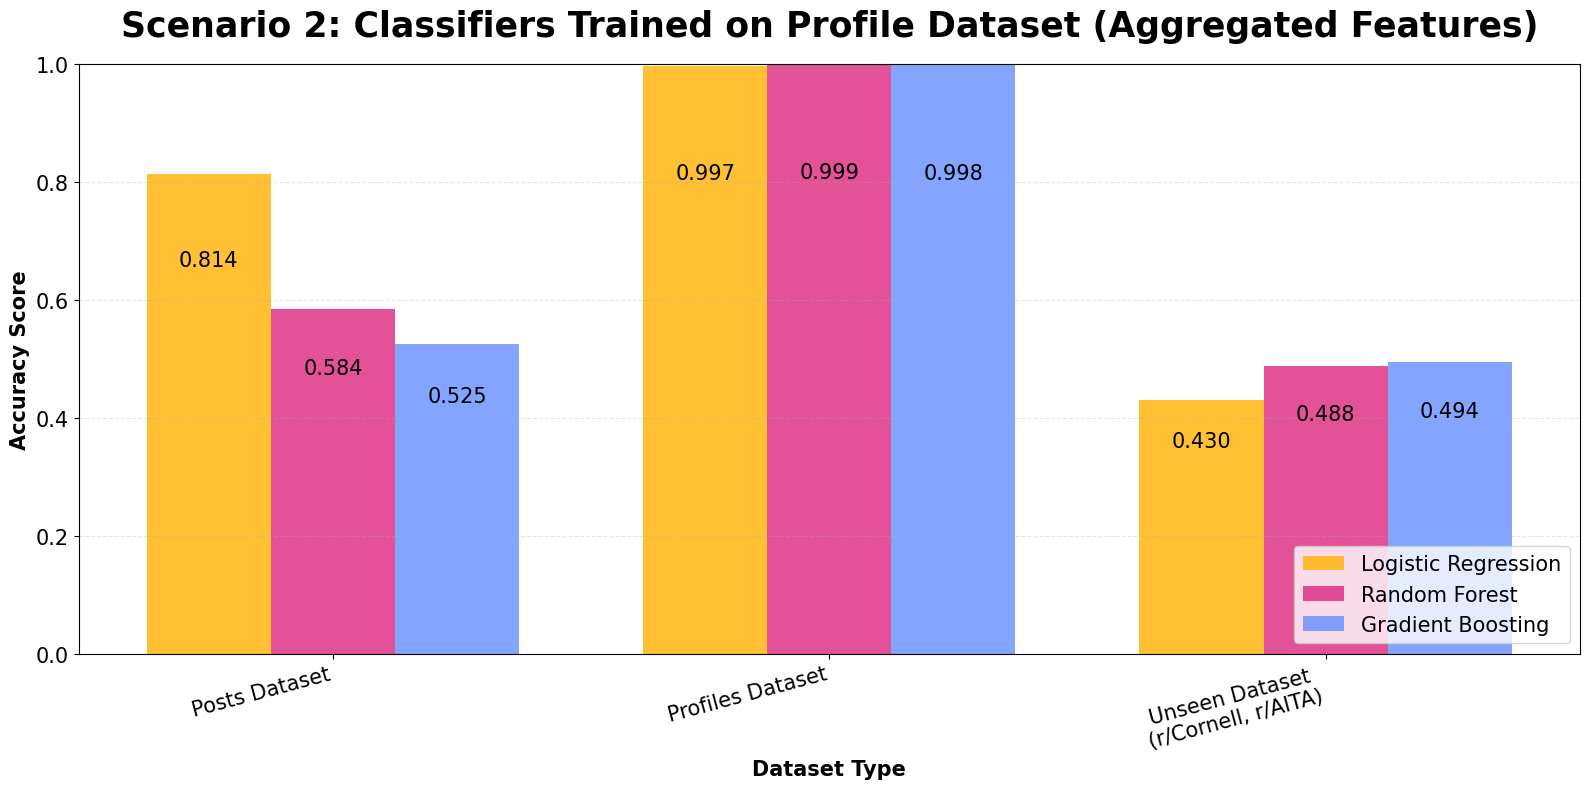

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for each classifier
colors = ['#FFB200', '#DC267F', '#648FFF']
classifiers = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# ===== PLOT 1: Trained on Posts Dataset =====
plt.figure(figsize=(16, 8))
test_types = list(profiles_results['Logistic Regression'].keys())
for i in range(len(test_types)):
    if test_types[i] == "Unseen Dataset":
        test_types[i] = "Unseen Dataset \n (r/Cornell, r/AITA)"
        break

x = np.arange(len(test_types))
width = 0.25

for idx, classifier in enumerate(classifiers):
    values = list(profiles_results[classifier].values())
    offset = (idx - 1) * width
    bars = plt.bar(x + offset, values, width, label=classifier, color=colors[idx], alpha=0.8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 0.8,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=15)

plt.xlabel('Dataset Type', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy Score', fontweight='bold', fontsize=15)
plt.title('Scenario 2: Classifiers Trained on Profile Dataset (Aggregated Features)', fontweight='bold', fontsize=25, pad=20)
plt.xticks(x, test_types, rotation=15, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
# plt.savefig('scenario1_posts_trained.png', dpi=300, bbox_inches='tight')
plt.show()

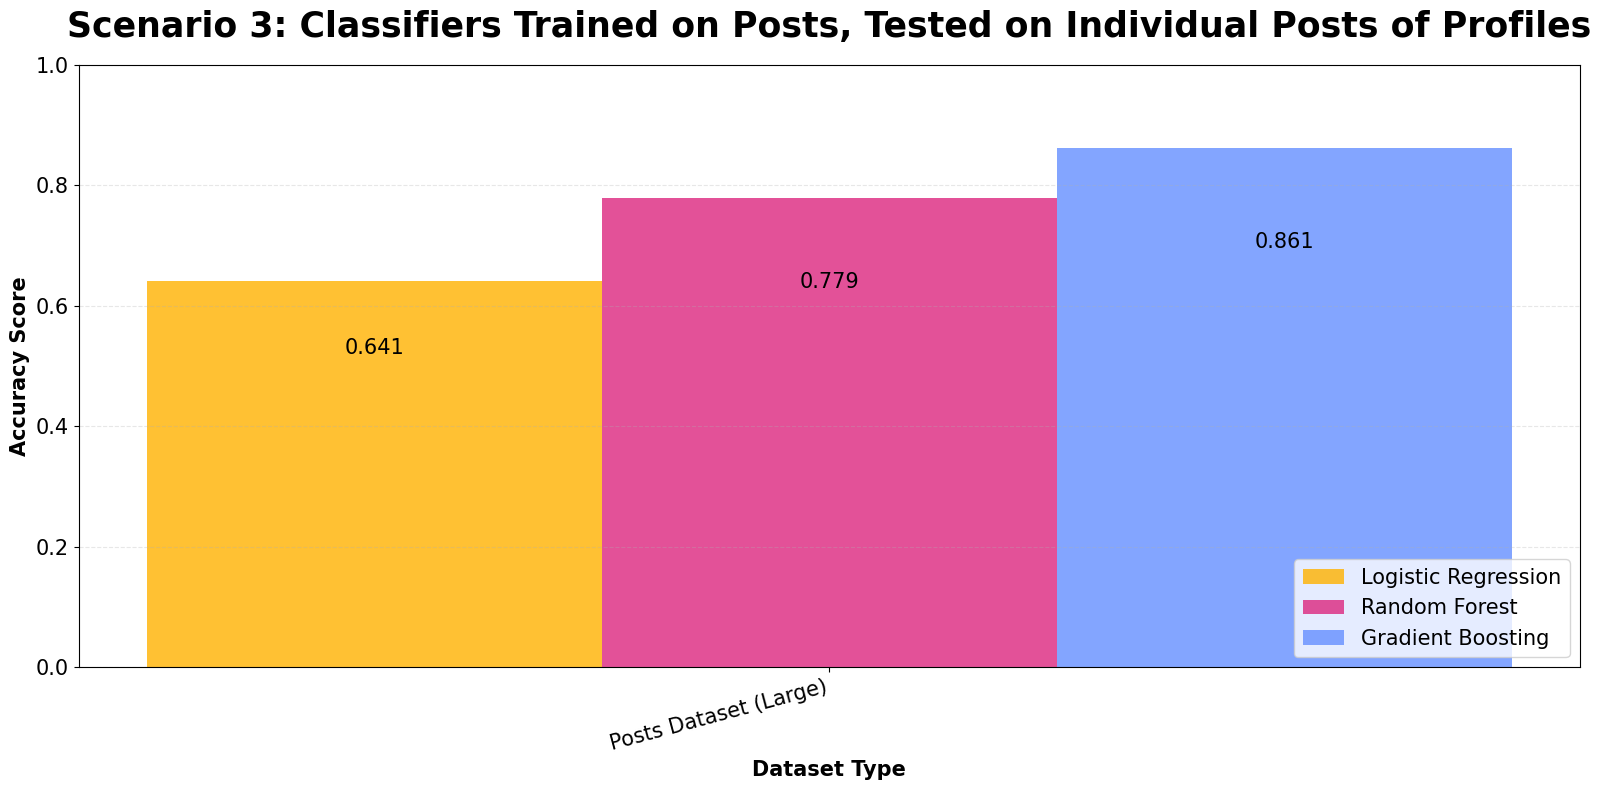

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for each classifier
colors = ['#FFB200', '#DC267F', '#648FFF']
classifiers = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# ===== PLOT 1: Trained on Posts Dataset =====
plt.figure(figsize=(16, 8))
test_types = list(posts_profiles_results['Logistic Regression'].keys())

x = np.arange(len(test_types))
width = 0.25

for idx, classifier in enumerate(classifiers):
    values = list(posts_profiles_results[classifier].values())
    offset = (idx - 1) * width
    bars = plt.bar(x + offset, values, width, label=classifier, color=colors[idx], alpha=0.8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 0.8,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=15)

plt.xlabel('Dataset Type', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy Score', fontweight='bold', fontsize=15)
plt.title('Scenario 3: Classifiers Trained on Posts, Tested on Individual Posts of Profiles', fontweight='bold', fontsize=25, pad=20)
plt.xticks(x, test_types, rotation=15, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
# plt.savefig('scenario1_posts_trained.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.tree import plot_tree

# Extract and visualize an individual decision tree (e.g., the first one)
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0],
          feature_names=X_posts_large.columns,
          class_names=["AI", "Human"],
          filled=True)
plt.title("Individual Decision Tree from Random Forest")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')


def visualize_feature_importance(X, y, top_n=20):


    print("Computing Random Forest importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(X, y)
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Computing Gradient Boosting importance...")
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
    gb.fit(X, y)
    gb_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': gb.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Computing Logistic Regression coefficients...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_scaled, y)
    lr_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(lr.coef_[0])
    }).sort_values('importance', ascending=False)

    print("Computing KS statistics...")
    ks_results = []
    for col in X.columns:
        class_0 = X[y == 0][col].dropna()
        class_1 = X[y == 1][col].dropna()
        stat, p_val = ks_2samp(class_0, class_1)
        ks_results.append({'feature': col, 'importance': stat, 'p_value': p_val})
    ks_importance = pd.DataFrame(ks_results).sort_values('importance', ascending=False)

    fig = plt.figure(figsize=(20, 12))

    ax1 = plt.subplot(2, 3, 1)
    top_rf = rf_importance.head(top_n)
    ax1.barh(range(len(top_rf)), top_rf['importance'])
    ax1.set_yticks(range(len(top_rf)))
    ax1.set_yticklabels(top_rf['feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Importance')
    ax1.set_title('Random Forest Feature Importance')
    ax1.grid(axis='x', alpha=0.3)

    ax2 = plt.subplot(2, 3, 2)
    top_gb = gb_importance.head(top_n)
    ax2.barh(range(len(top_gb)), top_gb['importance'], color='coral')
    ax2.set_yticks(range(len(top_gb)))
    ax2.set_yticklabels(top_gb['feature'])
    ax2.invert_yaxis()
    ax2.set_xlabel('Importance')
    ax2.set_title('Gradient Boosting Feature Importance')
    ax2.grid(axis='x', alpha=0.3)

    ax3 = plt.subplot(2, 3, 3)
    top_lr = lr_importance.head(top_n)
    ax3.barh(range(len(top_lr)), top_lr['importance'], color='green')
    ax3.set_yticks(range(len(top_lr)))
    ax3.set_yticklabels(top_lr['feature'])
    ax3.invert_yaxis()
    ax3.set_xlabel('|Coefficient|')
    ax3.set_title('Logistic Regression (Absolute Coefficients)')
    ax3.grid(axis='x', alpha=0.3)

    ax4 = plt.subplot(2, 3, 4)
    top_ks = ks_importance.head(top_n)
    colors = ['red' if p < 0.05 else 'lightblue' for p in top_ks['p_value']]
    ax4.barh(range(len(top_ks)), top_ks['importance'], color=colors)
    ax4.set_yticks(range(len(top_ks)))
    ax4.set_yticklabels(top_ks['feature'])
    ax4.invert_yaxis()
    ax4.set_xlabel('KS Statistic')
    ax4.set_title('KS Test Statistics (red = p<0.05)')
    ax4.grid(axis='x', alpha=0.3)

    # Plot 5: Consensus Ranking (average rank across methods)
    ax5 = plt.subplot(2, 3, 5)

    # Create rank for each method
    rf_importance['rf_rank'] = range(len(rf_importance))
    gb_importance['gb_rank'] = range(len(gb_importance))
    lr_importance['lr_rank'] = range(len(lr_importance))
    ks_importance['ks_rank'] = range(len(ks_importance))

    # Merge all rankings
    consensus = rf_importance[['feature', 'rf_rank']].copy()
    consensus = consensus.merge(gb_importance[['feature', 'gb_rank']], on='feature')
    consensus = consensus.merge(lr_importance[['feature', 'lr_rank']], on='feature')
    consensus = consensus.merge(ks_importance[['feature', 'ks_rank']], on='feature')

    # Average rank
    consensus['avg_rank'] = consensus[['rf_rank', 'gb_rank', 'lr_rank', 'ks_rank']].mean(axis=1)
    consensus = consensus.sort_values('avg_rank')

    top_consensus = consensus.head(top_n)
    ax5.barh(range(len(top_consensus)), 1 / (top_consensus['avg_rank'] + 1), color='purple')
    ax5.set_yticks(range(len(top_consensus)))
    ax5.set_yticklabels(top_consensus['feature'])
    ax5.invert_yaxis()
    ax5.set_xlabel('Consensus Score')
    ax5.set_title('Consensus Feature Importance (All Methods)')
    ax5.grid(axis='x', alpha=0.3)

    # Plot 6: Heatmap of Rankings
    ax6 = plt.subplot(2, 3, 6)

    # Get top features from consensus
    top_features = top_consensus['feature'].head(15).tolist()

    # Create matrix of ranks for these features
    rank_matrix = []
    for feat in top_features:
        ranks = [
            rf_importance[rf_importance['feature'] == feat]['rf_rank'].values[0],
            gb_importance[gb_importance['feature'] == feat]['gb_rank'].values[0],
            lr_importance[lr_importance['feature'] == feat]['lr_rank'].values[0],
            ks_importance[ks_importance['feature'] == feat]['ks_rank'].values[0]
        ]
        rank_matrix.append(ranks)

    rank_df = pd.DataFrame(rank_matrix,
                          columns=['RF', 'GB', 'LR', 'KS'],
                          index=top_features)

    sns.heatmap(rank_df, annot=True, fmt='.0f', cmap='YlOrRd_r',
                ax=ax6, cbar_kws={'label': 'Rank'})
    ax6.set_title('Feature Rank Across Methods (lower=better)')
    ax6.set_ylabel('Feature')

    plt.tight_layout()
    plt.show()

    # Return the consensus dataframe for further analysis
    return consensus.sort_values('avg_rank')

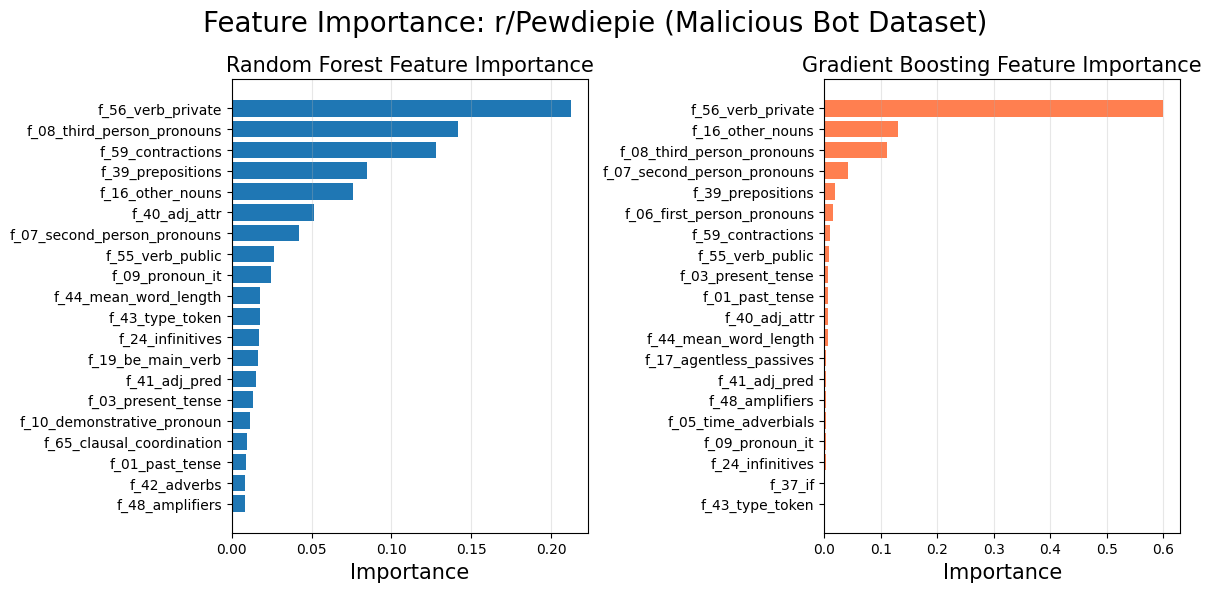

In [ ]:
TOP_N = 5

fig = plt.figure(figsize=(12, 6))
plt.suptitle("Feature Importance: r/Pewdiepie (Malicious Bot Dataset)", fontsize=20)

# Plot 1: Random Forest Importance
ax1 = plt.subplot(1, 2, 1)
top_rf = rf_importance.head(TOP_N)
ax1.barh(range(len(top_rf)), top_rf['importance'])
ax1.set_yticks(range(len(top_rf)))
ax1.set_yticklabels(top_rf['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance', fontsize=15)
ax1.set_title('Random Forest Feature Importance', fontsize=15)
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Gradient Boosting Importance
ax2 = plt.subplot(1, 2, 2)
top_gb = gb_importance.head(TOP_N)
ax2.barh(range(len(top_gb)), top_gb['importance'], color='coral')
ax2.set_yticks(range(len(top_gb)))
ax2.set_yticklabels(top_gb['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance', fontsize=15)
ax2.set_title('Gradient Boosting Feature Importance', fontsize=15)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# KS test significant features

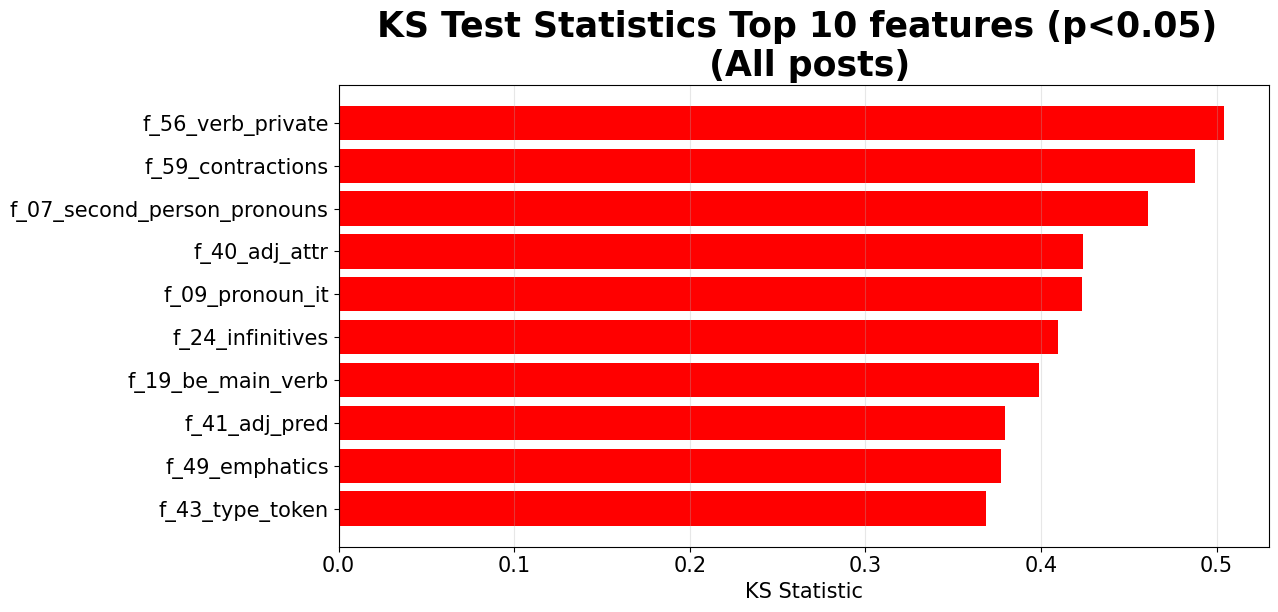

In [117]:
TOP_N = 10

ks_results = []
for col in X_posts_large.columns:
    class_0 = X_posts_large[y_posts_large == 0][col].dropna()
    class_1 = X_posts_large[y_posts_large == 1][col].dropna()
    stat, p_val = ks_2samp(class_0, class_1)
    ks_results.append({'feature': col, 'importance': stat, 'p_value': p_val})
ks_importance = pd.DataFrame(ks_results).sort_values('importance', ascending=False)



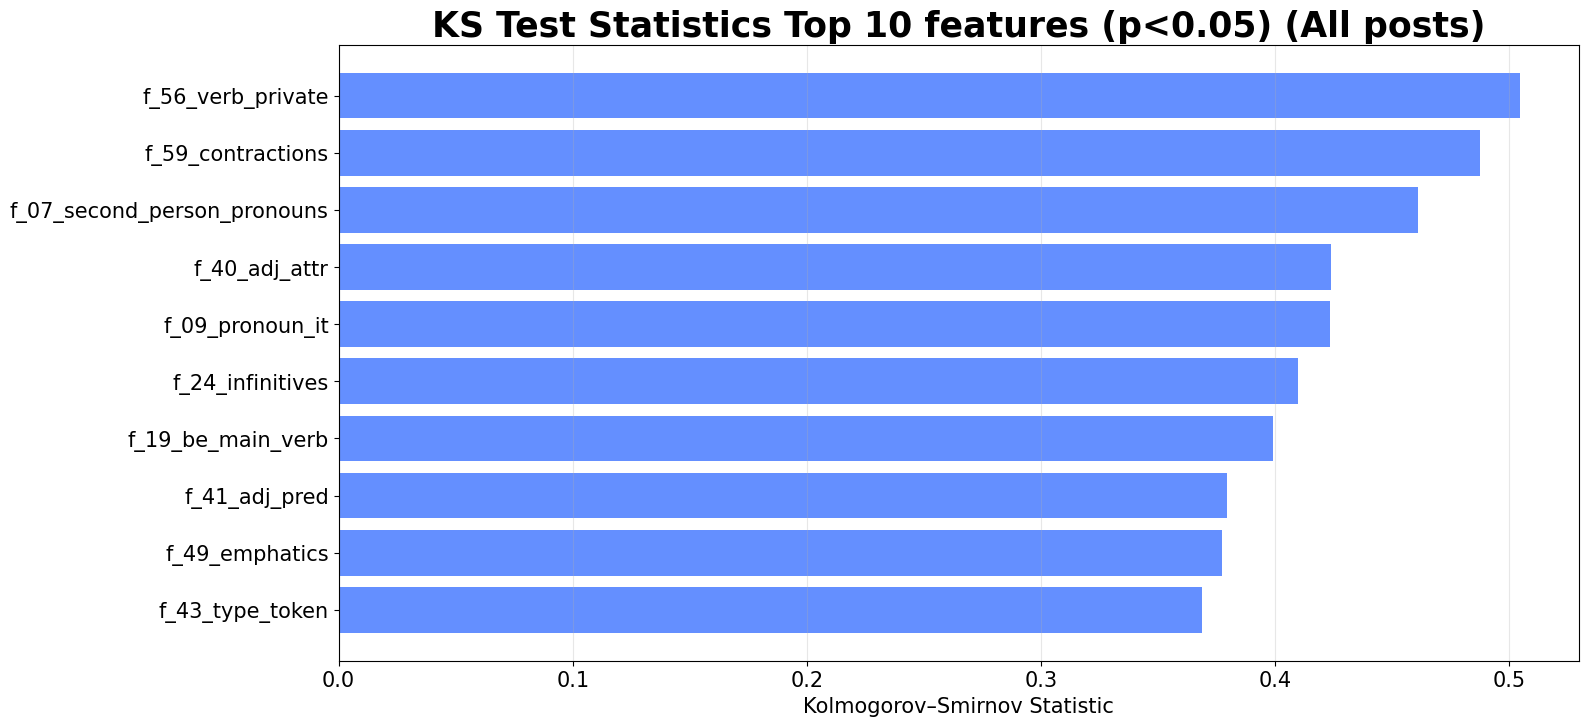

In [122]:
fig = plt.figure(figsize=(16, 8))

top_ks = ks_importance.head(TOP_N)
colors = ['#648FFF' if p < 0.05 else 'red' for p in top_ks['p_value']]
plt.barh(range(len(top_ks)), top_ks['importance'], color=colors)
plt.yticks(range(len(top_ks)), top_ks['feature'], fontsize=15)
plt.gca().invert_yaxis()
plt.xlabel('Kolmogorov–Smirnov Statistic', fontsize=15)
plt.xticks(fontsize=15)
plt.title('KS Test Statistics Top 10 features (p<0.05) (All posts)', fontweight='bold', fontsize=25)
plt.grid(axis='x', alpha=0.3)
plt.show()